# Homework 3 Part 2 Task 1 - Classification with GridSearchCV
Student: Alex Ramos

The dataset is from https://www.kaggle.com/c/GiveMeSomeCredit <br>
"Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted."  <br>
In this task, we will build classifiers to predict if someone will experience financial distress and therefore cannot pay off credit card (i.e. default). It is a binary classificaiton problem: default (class-1) or not default  (class-0) <br>

### Create your "signature"
Run the cell below but do NOT modify the cell. \
The signature needs to be displayed right below the cell in this file. \
You will get zero point if the signature is not displayed. 

In [1]:
import platform, socket, getpass
from time import time
from datetime import datetime
import random

signature = [
    socket.gethostbyname(socket.gethostname()),
    getpass.getuser(),
    datetime.now(),
    random.random(),
]
print(signature)

['192.168.1.162', 'poh', datetime.datetime(2025, 11, 3, 19, 3, 42, 555895), 0.5108294126021915]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#every row of the table is a data sample (feature vector) from a person
df = pd.read_csv('cs_data.csv')
df.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#### handle nan (null) in data (i.e. missing values)
Some fields in the table are nan, which are missing values. <br>
For example, someone may not want to reveal monthly income to whoever made the table/survey, then the table got nan.

In [4]:
df.isnull().sum()

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [5]:
#here, we use a simple method:
#replace nan in each column with median value of that column
#there are other methods in pandas and sklearn: interpolation in pandas and KNNImputer in sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dfv=imputer.fit_transform(df.values)
df=pd.DataFrame(data=dfv, columns=df.columns)
df.isnull().sum()

id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### We have a highly imbalanced dataset
139974 data samples in class-0 (normal) <br>
10026 data samples in class-1 (financial distress)

<Axes: >

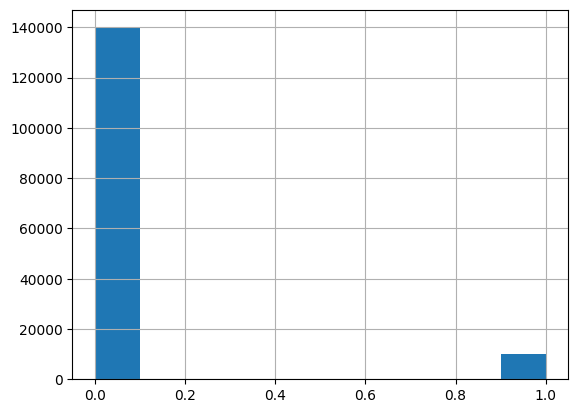

In [6]:
df['SeriousDlqin2yrs'].hist()

In [7]:
(df['SeriousDlqin2yrs']==0).sum()

np.int64(139974)

#### Classification Goal: predict 'SeriousDlqin2yrs' (Y) using the other features (X)

In [8]:
#'SeriousDlqin2yrs' is the target/class label, so it should not be in the input feature vector X
#'id' of a person is useless for the classification task
#so, we remove them from the table and get the input X
X=df.drop(['SeriousDlqin2yrs', 'id'], axis=1)
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [9]:
#Y is the target/class label
Y=df['SeriousDlqin2yrs']
Y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SeriousDlqin2yrs, dtype: float64

In [10]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X=X.values
Y=Y.values

## GridSearchCV for Random Forest Hyperparameter Optimization
We will optimize more than one hyper-parameter of random forest using GridSearchCV <br>
We will consider the following hyper-parameters: <br>
`max_depth` <br>
`min_samples_split` <br>
`min_samples_leaf` <br>
`max_features` <br>
`max_samples` <br>
For each of the above hyper-parameters, we try at least three different values <br>
We fix: <br>
`n_estimators`=20 <br>
`class_weight`="balanced"

In [11]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('test:', X_test.shape, Y_test.shape)

train: (120000, 10) (120000,)
test: (30000, 10) (30000,)


In [12]:
# Create train and validation indices for GridSearchCV
N_train = int(0.9 * X_train.shape[0])
idx_list = np.arange(0, X_train.shape[0])
np.random.seed(0)
np.random.shuffle(idx_list)
train_idx = idx_list[0:N_train]
val_idx = idx_list[N_train:]
print('Pure training samples:', len(train_idx))
print('Validation samples:', len(val_idx))

Pure training samples: 108000
Validation samples: 12000


In [13]:
#apply feature normalization to training and test sets
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# Define weighted accuracy scorer for imbalanced dataset
from sklearn.metrics import confusion_matrix

def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M = confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k] /= M[k].sum() + 1e-8
    acc = M.diagonal().sum() / M.sum()
    return acc

def my_scorer(model, X, Y_true):
    Y_pred = model.predict(X)
    confusion = confusion_matrix(Y_true, Y_pred)
    acc = weighted_accuracy(confusion)
    return acc

In [15]:
# Define parameter grid for GridSearchCV
# Testing at least 3 values for each hyperparameter
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'max_samples': [0.3, 0.6, 0.9],
    'n_estimators': [20],  # fixed
    'class_weight': ['balanced']  # fixed to handle imbalanced data
}

print('Total number of parameter combinations:', 
      len(param_grid['max_depth']) * 
      len(param_grid['min_samples_split']) * 
      len(param_grid['min_samples_leaf']) * 
      len(param_grid['max_features']) * 
      len(param_grid['max_samples']))

Total number of parameter combinations: 243


In [16]:
# Perform GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=param_grid,
    scoring=my_scorer,  # use weighted accuracy
    cv=[(train_idx, val_idx)],  # single train-validation split
    verbose=2,
    n_jobs=-1  # use all available processors
)

print('Starting GridSearchCV...')
gs.fit(X_train, Y_train)
print('GridSearchCV completed!')

Starting GridSearchCV...
Fitting 1 folds for each of 243 candidates, totalling 243 fits
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, max_samples=0.3, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   1.1s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, max_samples=0.3, min_samples_leaf=1, min_samples_split=20, n_estimators=20; total time=   1.1s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, max_samples=0.3, min_samples_leaf=5, min_samples_split=10, n_estimators=20; total time=   1.2s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, max_samples=0.3, min_samples_leaf=10, min_samples_split=10, n_estimators=20; total time=   1.2s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, max_samples=0.3, min_samples_leaf=5, min_samples_split=2, n_estimators=20; total time=   1.3s
[CV] END class_weight=balanced, max_depth=5, max_features=sqrt, max_samples=0.3, min_samples_leaf=5, min_samples_split

In [17]:
# Display the best parameters found
print('Best parameters found:')
print(gs.best_params_)
print('\nBest validation score (weighted accuracy):', gs.best_score_)

Best parameters found:
{'class_weight': 'balanced', 'max_depth': 5, 'max_features': None, 'max_samples': 0.3, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 20}

Best validation score (weighted accuracy): 0.7875261306762695


In [18]:
# Get the best model
model_best = gs.best_estimator_
model_best

,n_estimators,20
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
# Evaluate on training set
Y_train_pred = model_best.predict(X_train)
confusion_train = confusion_matrix(Y_train, Y_train_pred)
acc_train = weighted_accuracy(confusion_train)
print('Weighted accuracy on training set:', acc_train)
print('\nConfusion matrix on training set:')
print(confusion_train)

Weighted accuracy on training set: 0.78058696

Confusion matrix on training set:
[[88329 23688]
 [ 1815  6168]]


In [20]:
# Evaluate on test set (final evaluation)
Y_test_pred = model_best.predict(X_test)
confusion_test = confusion_matrix(Y_test, Y_test_pred)
acc_test = weighted_accuracy(confusion_test)
print('Weighted accuracy on test set:', acc_test)
print('\nConfusion matrix on test set:')
print(confusion_test)

Weighted accuracy on test set: 0.7681414

Confusion matrix on test set:
[[22095  5862]
 [  519  1524]]


In [21]:
# Visualize top parameter combinations
import pandas as pd

results_df = pd.DataFrame(gs.cv_results_)
results_df = results_df.sort_values('rank_test_score')
print('Top 10 parameter combinations:')
print(results_df[['params', 'mean_test_score', 'rank_test_score']].head(10))

Top 10 parameter combinations:
                                               params  mean_test_score  \
61  {'class_weight': 'balanced', 'max_depth': 5, '...         0.787526   
62  {'class_weight': 'balanced', 'max_depth': 5, '...         0.787526   
60  {'class_weight': 'balanced', 'max_depth': 5, '...         0.787526   
57  {'class_weight': 'balanced', 'max_depth': 5, '...         0.787063   
59  {'class_weight': 'balanced', 'max_depth': 5, '...         0.787063   
58  {'class_weight': 'balanced', 'max_depth': 5, '...         0.787063   
54  {'class_weight': 'balanced', 'max_depth': 5, '...         0.785734   
55  {'class_weight': 'balanced', 'max_depth': 5, '...         0.785734   
56  {'class_weight': 'balanced', 'max_depth': 5, '...         0.785734   
66  {'class_weight': 'balanced', 'max_depth': 5, '...         0.784191   

    rank_test_score  
61                1  
62                1  
60                1  
57                4  
59                4  
58                4  


In [22]:
# Analyze the impact of each hyperparameter
# Group by each parameter to see its effect on validation accuracy
print('Average validation score by max_depth:')
for depth in param_grid['max_depth']:
    mask = results_df['param_max_depth'] == depth
    avg_score = results_df[mask]['mean_test_score'].mean()
    print(f'  max_depth={depth}: {avg_score:.4f}')

print('\nAverage validation score by min_samples_split:')
for split in param_grid['min_samples_split']:
    mask = results_df['param_min_samples_split'] == split
    avg_score = results_df[mask]['mean_test_score'].mean()
    print(f'  min_samples_split={split}: {avg_score:.4f}')

print('\nAverage validation score by min_samples_leaf:')
for leaf in param_grid['min_samples_leaf']:
    mask = results_df['param_min_samples_leaf'] == leaf
    avg_score = results_df[mask]['mean_test_score'].mean()
    print(f'  min_samples_leaf={leaf}: {avg_score:.4f}')

print('\nAverage validation score by max_features:')
for feat in param_grid['max_features']:
    mask = results_df['param_max_features'] == feat
    avg_score = results_df[mask]['mean_test_score'].mean()
    print(f'  max_features={feat}: {avg_score:.4f}')

print('\nAverage validation score by max_samples:')
for samp in param_grid['max_samples']:
    mask = results_df['param_max_samples'] == samp
    avg_score = results_df[mask]['mean_test_score'].mean()
    print(f'  max_samples={samp}: {avg_score:.4f}')

Average validation score by max_depth:
  max_depth=5: 0.7777
  max_depth=10: 0.7704
  max_depth=15: 0.7424

Average validation score by min_samples_split:
  min_samples_split=2: 0.7610
  min_samples_split=10: 0.7632
  min_samples_split=20: 0.7663

Average validation score by min_samples_leaf:
  min_samples_leaf=1: 0.7567
  min_samples_leaf=5: 0.7643
  min_samples_leaf=10: 0.7696

Average validation score by max_features:
  max_features=sqrt: 0.7633
  max_features=log2: 0.7633
  max_features=None: nan

Average validation score by max_samples:
  max_samples=0.3: 0.7595
  max_samples=0.6: 0.7648
  max_samples=0.9: 0.7663
